In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import time
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from fourier_learning_ibm.calc_expected_value import calculate_expected_value
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
import networkx as nx

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
n_qubits = 4
n_samples = 55
beta = 1.0

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハミルトニアンは、開放境界条件の 1 次元ハイゼンベルグ模型 : 

\begin{aligned}
H=\sum_{i=0}^{n-2} J_i\left(X_i X_{i+1}+Y_i Y_{i+1}+Z_i Z_{i+1}\right)
\end{aligned}

相互作用強度 $J_i$ は $[-1, 1]$ の一様分布からランダムに選ぶ。

これを networkx のグラフとして表す。

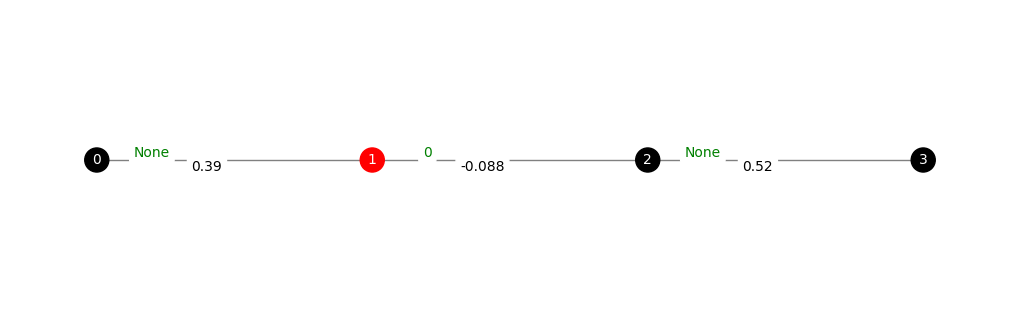

In [6]:
rng = np.random.default_rng(42)

# -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
Js = rng.uniform(-1, 1, size=n_qubits - 1)
Js /= np.sum(np.abs(Js))

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

## データセットの作成

教師あり学習用のデータセット、すなわち input と output が組になったデータセットを作る。

input: Hamiltonian $H$

output: $y(H)=\operatorname{Tr}[f(H)\rho]$

今回は
- $f(H)=e^{-\beta H}$
- $\rho$ は純粋状態 $\rho=\ket{\psi}\bra{\psi}, \ket{\psi}=\ket{0011\cdots1100}$ (真ん中半分が 1, それ以外は 0)

とする。すなわち

output: $y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$

となる。以下ではまず、$\ket{\psi}=\ket{0011\cdots1100}$ を作成する。

次に、$y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$ を虚時間 TEBD で計算してデータセットを作る。12 量子ビット以下は厳密対角化と比較して、虚時間 TEBD の結果が合っているか確かめる。

In [7]:
data = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    data.append(
        {
            "sample": i,
            "Js": Js,
            "expected_value": expected_value_tebd,
            "expected_value_diag": expected_value_diag,
            "diff": diff,
        }
    )

df = pd.DataFrame(data)
print(f"diff mean: {df['diff'].mean():.3e}")
print(
    "Note: The expected value is calculated by TEBD. \nFor small number of qubits, to check the accuracy, the expected value is also calculated by diagonalizing the Hamiltonian."
)
display(df)
df["expected_value"].describe()

# json に保存 (orient="records" で行ごとに保存)
df.to_json(f"results/get_dataset/{n_qubits}Q/dataset.json", orient="records", indent=4)

Sample 0/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 1/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.01[s]

Sample 2/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 3/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.01[s]

Sample 4/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 5/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 6/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 7/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.01[s]

Sample 8/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 9/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 10/55
Elapsed time for TEBD: 0.42[s]
Elapsed time for diagonalization: 0.00[s]

Sample 11/55
Elapsed time for TEBD: 0.42[s]
Elapsed t

,sample,Js,expected_value,expected_value_diag,diff
0,0,"[0.394933996105265, -0.08811260844266271, 0.51...",5.547457,5.547450,6.426329e-06
1,1,"[0.1829492442685424, -0.37617514784362005, 0.4...",3.841905,3.841881,2.462770e-05
2,2,"[0.2841284265503763, 0.3112471996064773, -0.40...",1.129636,1.129639,3.412132e-06
3,3,"[-0.08192803260881482, -0.2133520867836908, 0....",4.731457,4.731416,4.172407e-05
4,4,"[0.2749649723348141, 0.6168843289742019, -0.10...",0.852425,0.852410,1.459609e-05
5,5,"[-0.357237703351539, 0.07149014727846889, -0.5...",0.828226,0.828227,1.070754e-06
6,6,"[0.45670308589215564, 0.18353423764740212, 0.3...",3.697788,3.697784,4.380695e-06
7,7,"[-0.1441345637725352, 0.46636402072996397, 0.3...",1.258985,1.258995,1.064275e-05
8,8,"[0.4511714193489968, -0.49489387496331066, -0....",3.279570,3.279566,4.387366e-06
9,9,"[-0.463164217790743, -0.35099092228344414, 0.1...",1.577586,1.577586,7.131915e-08


In [ ]:
# ノルムが 3 以下になっているか確認 (ノルムを求めるのは、量子ビット数が多くなってくると難しくなる)
for i in range(n_samples):
    Js = df["Js"].values[i]
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)
    H = heisenberg.get_hamiltonian()
    norm = scipy.sparse.linalg.norm(H.to_matrix(sparse=True), ord=2)
    print(f"Js: {Js}, norm: {norm:.3e}")

Js: [ 0.394934   -0.08811261  0.5169534 ], norm: 2.742e+00
Js: [ 0.18294924 -0.37617515  0.44087561], norm: 1.997e+00
Js: [ 0.28412843  0.3112472  -0.40462437], norm: 1.610e+00
Js: [-0.08192803 -0.21335209  0.70471988], norm: 2.236e+00
Js: [ 0.27496497  0.61688433 -0.1081507 ], norm: 2.003e+00
Js: [-0.3572377   0.07149015 -0.57127215], norm: 2.790e+00
Js: [0.45670309 0.18353424 0.35976268], norm: 2.484e+00
Js: [-0.14413456  0.46636402  0.38950142], norm: 1.816e+00
Js: [ 0.45117142 -0.49489387 -0.05393471], norm: 1.702e+00
Js: [-0.46316422 -0.35099092  0.18584486], norm: 1.808e+00
Js: [ 0.2761161   0.52739755 -0.19648635], norm: 1.815e+00
Js: [-0.27531707 -0.06470423 -0.6599787 ], norm: 2.809e+00
Js: [-0.55445443 -0.03639907 -0.4091465 ], norm: 2.892e+00
Js: [ 0.30037484 -0.11116859  0.58845657], norm: 2.676e+00
Js: [ 0.27808485 -0.26054462  0.46137053], norm: 2.276e+00
Js: [ 0.48455448 -0.17890168 -0.33654384], norm: 1.827e+00
Js: [ 0.21652582 -0.42742363 -0.35605055], norm: 1.726e+00


### (付録) 量子ビットを増やした時の TEBD と厳密対角化の比較

In [12]:
n_qubits_list = [4, 8, 12, 20, 40, 60, 80, 100]
expected_values_tebd = []
expected_values_diag = []
diffs = []
rng = np.random.default_rng(42)
n_qubits_diag_upper_bound = 12

for n_qubits in n_qubits_list:
    print(f"processing for {n_qubits} qubits...")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    expected_values_tebd.append(expected_value_tebd)
    expected_values_diag.append(expected_value_diag)
    diffs.append(diff)

df = pd.DataFrame(
    {
        "n_qubits": n_qubits_list,
        "expected_value_tebd": expected_values_tebd,
        "expected_value_diag": expected_values_diag,
        "diff": diffs,
    }
)
display(df)

processing for 4 qubits...
Elapsed time for TEBD: 0.43[s]
Elapsed time for diagonalization: 0.00[s]

processing for 8 qubits...
Elapsed time for TEBD: 0.98[s]
Elapsed time for diagonalization: 0.03[s]

processing for 12 qubits...
Elapsed time for TEBD: 1.47[s]
Elapsed time for diagonalization: 17.95[s]

processing for 20 qubits...
Elapsed time for TEBD: 2.61[s]

processing for 40 qubits...
Elapsed time for TEBD: 4.91[s]

processing for 60 qubits...
Elapsed time for TEBD: 7.19[s]

processing for 80 qubits...
Elapsed time for TEBD: 9.51[s]

processing for 100 qubits...
Elapsed time for TEBD: 11.85[s]



,n_qubits,expected_value_tebd,expected_value_diag,diff
0,4,5.547457,5.547450,6.426329e-06
1,8,0.457030,0.457030,5.554053e-09
2,12,1.111247,1.111247,3.868693e-07
3,20,0.853209,NaN,NaN
4,40,1.034675,NaN,NaN
5,60,1.109520,NaN,NaN
6,80,1.061310,NaN,NaN
7,100,1.127011,NaN,NaN
